# Harmonic and damped oscillator - interpolation and fit

This notebook is used for analysis of the oscillation data from the first Tier 1 Lab of Phys 5BL.

For more details on the theory behind the various oscillator models, see the lab manual. 

The case of the constant-friction oscillator is handled differently than the other two, and is done at the end of the notebook.

## Data loading and interpolation

We choose to do interpolation so that the various fits and peak picking converge more quickly.


In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check the data and headers
file = open('P3T2.csv', 'r')
print(file.read())

Time (s),Fᵧ (N),rᵧ (m),vᵧ (m/s),aᵧ (m/s²)
2.4600000381469727,-0.7752519845962524,0.06480000168085098,0.03999999910593033,-4.03636360168457
2.4700000286102295,-0.7661527991294861,0.06499999761581421,0.019999999552965164,-4.0545454025268555
2.4800000190734863,-0.7661527991294861,0.06480000168085098,-0.019999999552965164,-4.0545454025268555
2.490000009536743,-0.7661527991294861,0.06419999897480011,-0.06000000238418579,-4.036363124847412
2.5,-0.7479544281959534,0.06320000439882278,-0.10000000149011612,-4.109090805053711
2.509999990463257,-0.7297561168670654,0.061600007116794586,-0.1599999964237213,-4.090909004211426
2.5199999809265137,-0.7115577459335327,0.05960000306367874,-0.20000000298023224,-4.090909004211426
2.5299999713897705,-0.6842601895332336,0.057200003415346146,-0.24000000953674316,-4.000000476837158
2.5399999618530273,-0.6569626331329346,0.0543999969959259,-0.2800000011920929,-3.8181819915771484
2.549999952316284,-0.6296650767326355,0.05120000243186951,-0.3199999928474426,-3.56

In [3]:
# Input the data into arrays. You might also want to look at the wheel output, to better choose the quietest sensor
t, f, x, v, a= np.loadtxt("P3T2.csv", delimiter=",", skiprows=1, usecols=(0,1,2,3,4), unpack=True)

In [4]:
# Define the function for plotting
def plot(title, x, y, xlabel, ylabel, color):
    fig = plt.figure()
    fig.set_size_inches(16, 4)
    ax = fig.add_subplot(111)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.plot(x, y, color)
    plt.show()

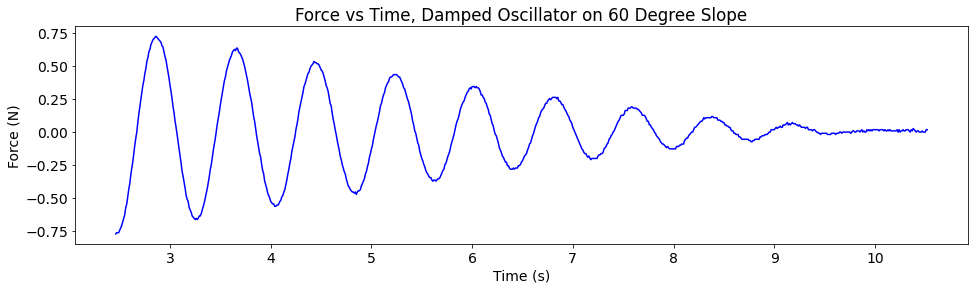

In [26]:
# Plot Force vs Time
plot("Force vs Time, Damped Oscillator on 60 Degree Slope", t, f, "Time (s)", "Force (N)", "b-")

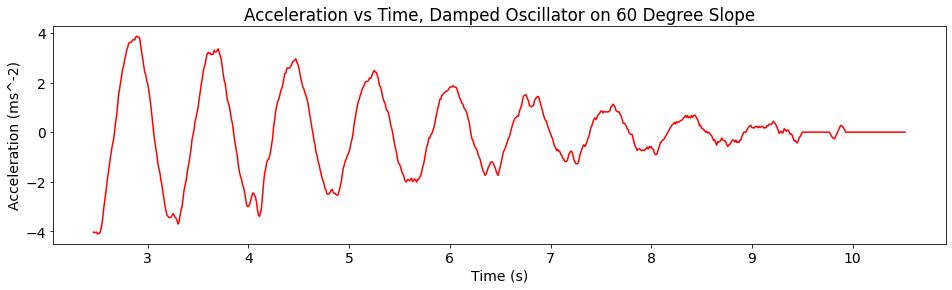

In [27]:
# Plot Accleration
plot("Acceleration vs Time, Damped Oscillator on 60 Degree Slope", t, a, "Time (s)", "Acceleration (ms^-2)", "r-")

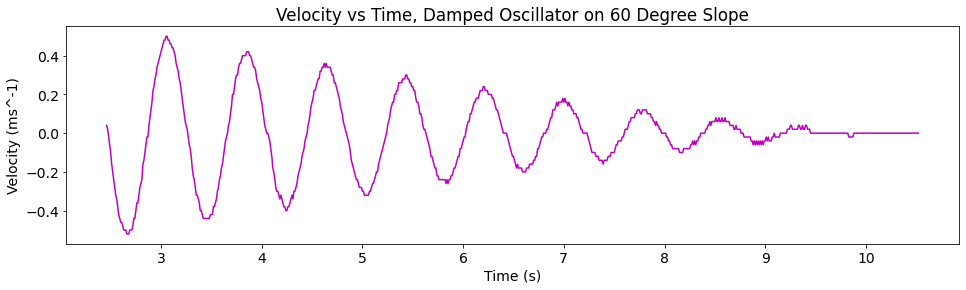

In [28]:
# Plot Velocity
plot("Velocity vs Time, Damped Oscillator on 60 Degree Slope", t, v, "Time (s)", "Velocity (ms^-1)", "m-")

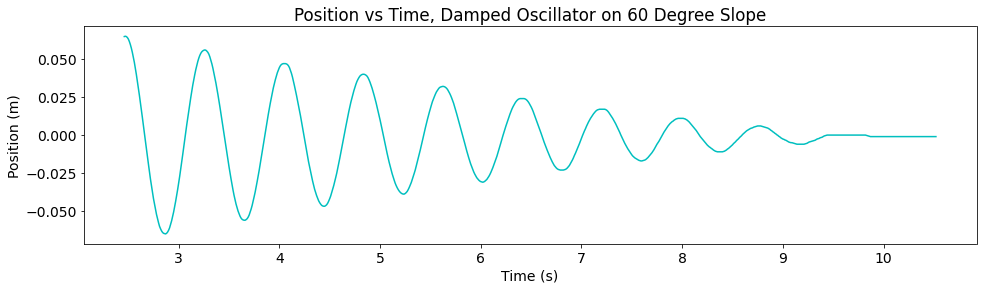

In [29]:
# Plot Position
plot("Position vs Time, Damped Oscillator on 60 Degree Slope", t, x, "Time (s)", "Position (m)", "c-")

## Interpolation

The online repository CSV files have already are have been interpolated. We're adding linear interpolation because the constant friction case behaves better with interpolation. We use the Python command:

`interp1d(tx, aydata)`



In [9]:
# Creates an interpolating function 
yinterp = interp1d(t, a, kind="linear")

### Select region in data for fitting and interpolation

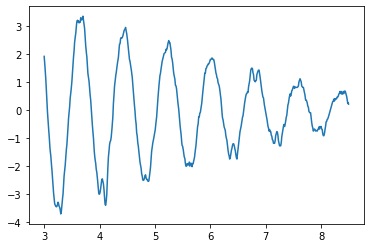

In [10]:
# Set the start time and stop time to select a good region of your data. Don't use the first peak to allow for IOLab sensor settling.
# Use the interpolating function to estimate values at the desired time points

start_time = 3
stop_time = 8.5
step_size = 0.005
tvals = np.arange(start_time, stop_time, step_size)  
yvals = yinterp(tvals)

plt.plot(tvals, yvals)
plt.show()

## Nonlinear fits

For the cases of simple harmonic motion, and motion with velocity-dependent friction, we fit to the full time series of data. We've defined 4 models below:

Simple harmonic motion for acceleration: $a_{harmonic} = B-A\omega^2\cos(\omega t+\phi),$

Simple harmonic motion for position: $y_{harmonic} = B+A\cos(\omega t+\phi),$

Velocity-dependent friction damping for acceleration: $a_{damped}=B+A\exp^{-\beta t}[(\beta^2-\omega^2)\cos(\omega t+\phi)+2\beta\omega\sin(\omega t + \phi],$

Velocity-dependent friction damping for position: $y_{damped}=B+A\exp^{-\beta t}\cos(\omega t+\phi),$

where t is time, A is the amplitude, B is the offset, $\omega=2\pi f$ is the angular frequency, $\phi$ is the phase, $\beta$ is the damping

### Define the model:

In [11]:
# Defines the various oscillator models that we fit to:

# Simple harmonic motion using acceleration
def simple_a(t, A, B, w, phi):                  # inputs: t:time, A:amplitude, B:offset, w:angular frequency, phi:phase
    return B - A * (w**2) * np.cos(w*t + phi)   # output: acceleration

# Simple harmonic motion using position
def simple_y(t, A, B, w, phi):       # inputs: t:time, A:amplitude, B:offset, w:angular frequency, phi:phase
    return B + A*np.cos(w*t + phi)   # output: position

# Velocity-dependent friction using acceleration
def vdamped_a(t, A, B, w, phi, beta):    # inputs: t:time, A:amplitude, B:offset, w:ang. frequency, phi:phase, beta:damping
    return B + A * np.exp(-beta*t) * ((beta**2-w**2)*np.cos(w*t + phi)+2*beta*w*np.sin(w*t+phi))   # output: acceleration

# Velocity-dependent friction using position
def vdamped_y(t, A, B, w, phi, beta):    # inputs: t:time, A:amplitude, B:offset, w:ang. frequency, phi:phase, beta:damping
    return B + A * np.exp(-beta*t) * np.cos(w*t + phi)        # output: position



### Choose the model and initial fit parameter values then graph:


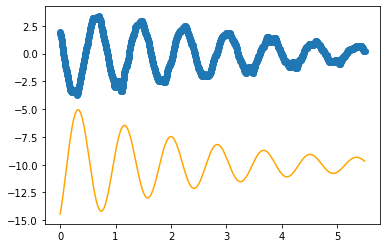

In [12]:
# Fits to the (nonlinear) harmonic function

# Choose the model you wish to fit to: simple_y, simple_a, vdamped_y, vdamped_a
# In this example, we chose simple_a  
oscillator_model = vdamped_a


# Initial guess values of fit parameters determined here:
    # If using simple_a or simple_y, fit parameters are:  [A, B, w, phi]
    # If using vdamped_a or vdamped_y, fit parameters are: [ A, B, w, phi, beta]

init_simple_parameters = (0.1, -10, 7.5, 0.56) # Ainit, Binit, winit, phiinit
init_damped_parameters = (0.1, -10, 7.5, 0.56, 0.4) # Ainit, Binit, winit, phiinit, betainit

# Graph
plt.plot(tvals-start_time, oscillator_model(tvals-start_time, *init_damped_parameters), color='orange')
plt.scatter(tvals-start_time, yvals)
plt.show()

# If using damped harmonic oscillator, code becomes:
    # plt.plot(tvals-start_time, oscillator_model(tvals-start_time, Ainit, Binit, winit, phiinit, betainit), color='orange')

## Perform the fit then plot

In [13]:
# Perform the fit
start_pars = list(init_damped_parameters)
    #If using damped harmonic oscillator code becomes: start_pars=[Ainit, Binit, winit, phiinit, betainit]

pars, cov = opt.curve_fit(oscillator_model, tvals-start_time, yvals, p0=init_damped_parameters)
    #If using damped harmonic oscillator code becomes: pars, cov = opt.curve_fit(oscillator_model, tvals-start_time, yvals, p0=start_pars)

[A, B, w, phi, beta] = pars
    # If using damped harmonic oscillator code becomes: [A, B, w, phi, beta] = pars

# Error in fitting parameters
std_errs = np.sqrt(np.diag(cov))

print(np.transpose([pars, std_errs]))

[[-6.47545364e-02  3.47855527e-04]
 [ 1.86125365e-04  5.41484018e-03]
 [ 7.98255987e+00  2.56427421e-03]
 [ 9.95857346e-01  4.99937476e-03]
 [ 2.84537417e-01  2.65479881e-03]]


### Values predicted from fit

In [14]:
# Choose simple harmonic oscillator model simple_a for this example:
ypred = oscillator_model(tvals-start_time, A, B, w, phi, beta) 

# For damped harmonic fit, use vdamped_a or vdamped_y for oscillator model: 
    #ypred = oscillator_model(tvals-start_time, A, B, w, phi, beta) 

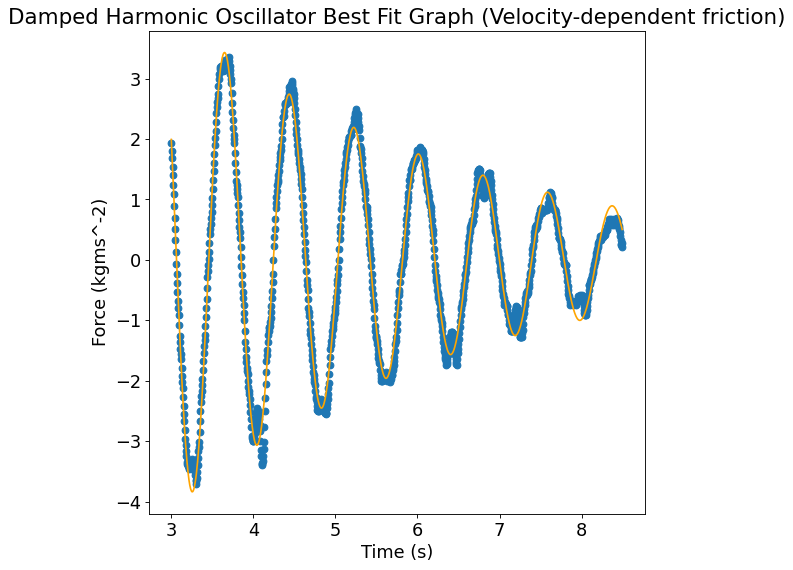

In [15]:
# Best-fit plots

# Sets figure size etc.
fig1=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '16'})

# Data and fit
plt.scatter(tvals, yvals)
plt.plot(tvals, ypred, color='orange')


# Axes label and title
plt.title("Damped Harmonic Oscillator Best Fit Graph (Velocity-dependent friction)")
plt.xlabel("Time (s)")
plt.ylabel("Force (kgms^-2)")
plt.show()

## Constant friction case 

Instead of fitting the full trajectory, we instead compare the amplitudes of successive extrema (turning points). The general equation is:
$$A_n-A_{n+1}=\frac{2f}{k}$$
where $f$ is the coefficient of static friction and $A_n$ is the amplitude for the nth peak. Successive turning points are a maximum followed by a minimum (or vice versa).

There are scipy functions that find these extrema well, but it is also not too hard to do it manually.

In [16]:
from scipy.signal import argrelextrema as get_extrema_indices

In [17]:
# How many neighboring points to compare to for min/max criteria
neighborhood_size = 40

max_indices = get_extrema_indices(yvals, np.greater, order=neighborhood_size)
min_indices = get_extrema_indices(yvals, np.less, order=neighborhood_size)

print("Maxima found: ", np.size(max_indices))
print("Minima found: ", np.size(min_indices))

Maxima found:  7
Minima found:  6


In [18]:
y_max = yvals[max_indices][:-1]
t_max = tvals[max_indices][:-1]

y_min = yvals[min_indices]
t_min = tvals[min_indices]

In [19]:
t_extrema = np.sort(np.append(t_max, t_min))

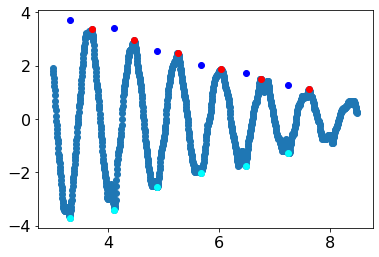

In [20]:
# Make a plot to check the  located max, min are in the right place 
# Be sure to check that the number of maxima, minima that appear on the plot are the same as what's printed above

plt.scatter(tvals, yvals)
plt.scatter(t_max, y_max, color='red')
plt.scatter(t_min, y_min, color='cyan')
plt.scatter(t_min, abs(y_min), color='blue')
plt.show()

Giving these maxima and minima, it's now up to you to define an appropriate function for evaluating the model given above (and from the lab manual).

In [21]:
# Define the model of a lienar function
def linear(x, m, b):
    return m * x + b

In [22]:
# Fit the change in amplitude to proportional and linear models
A_all = np.append(y_max, np.abs(y_min))
A_all = np.sort(A_all)[::-1]
delta_A = np.diff(A_all)
c_init = [0]

In [23]:
# Constant fit
mean_delta_A = np.mean(delta_A)
std_delta_A = np.std(delta_A)
print(f"Mean: {mean_delta_A}, STD: {std_delta_A}")

Mean: -0.2347107432093634, STD: 0.14220652708994208


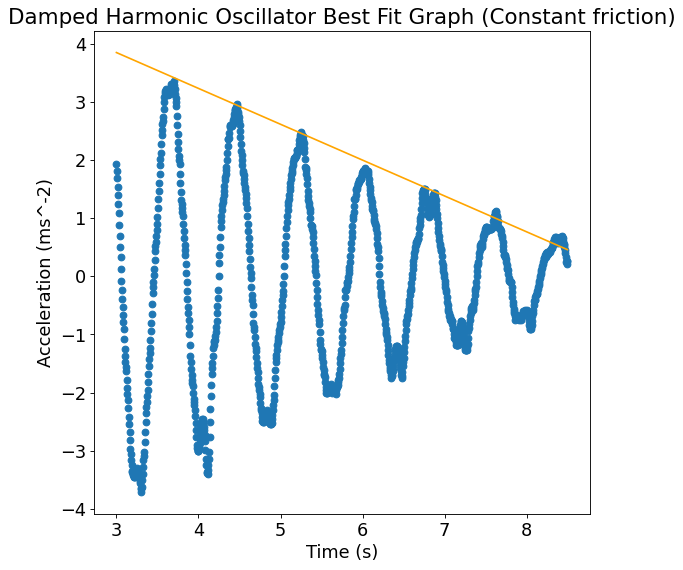

In [24]:
# Best-fit plots
pars_delta, cov = opt.curve_fit(linear, t_extrema, A_all, p0=[0, 0])
delta_pred = linear(tvals, *pars_delta)

# Sets figure size etc.
fig1=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '16'})

# Data and fit
plt.scatter(tvals, yvals)
plt.plot(tvals, delta_pred, color='orange')


# Axes label and title
plt.title("Damped Harmonic Oscillator Best Fit Graph (Constant friction)")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (ms^-2)")
plt.show()

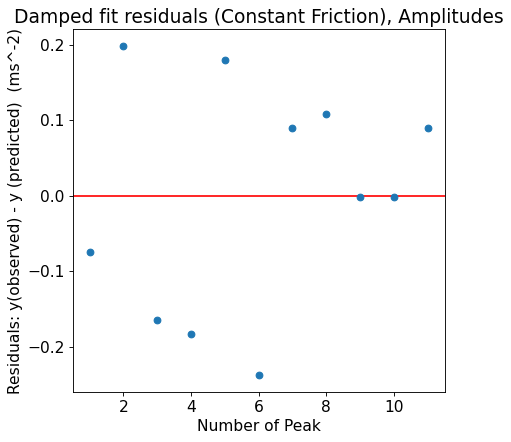

In [25]:
# Residuals plot of change in amplitude
residual = delta_A - mean_delta_A

# Sets figure size etc.
fig2=plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '14'})

# Residuals
plt.errorbar(np.arange(1, len(residual) + 1), residual, fmt='o')
plt.axhline(color='r') # 0 line for reference

# Axes label and title
plt.title("Damped fit residuals (Constant Friction), Amplitudes")
plt.xlabel("Number of Peak")
plt.ylabel("Residuals: y(observed) - y (predicted)  (ms^-2)")
plt.show()